## Исследовательский анализ данных в Python и проверка гипотез.

- Автор: Смирнов Александр Викторович
- Дата: 11.06.2025

## Цели и задачи проекта

Нужно провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

## Описание данных

В нашем распоряжении будут данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.

Первый датасет `orders_df` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.

Датасет содержит такие поля:
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например `mobile` для мобильных устройств, - `desktop` для стационарных.
- `days_since_prev` — количество дней с предыдущей покупки для каждого пользователя. 
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.

Второй датасет `events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.

Датасет содержит такие поля:
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Анализ данных в предыдущей части проекта показал, что выручка от заказов представлена в двух валютах — российских рублях и казахстанских тенге. Для удобства решения было бы корректно привести данные к одной валюте, например к российским рублям. Для этого в вашем распоряжении будет датасет `tenge_df` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. 

Датасет содержит такие поля:
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).


## Содержание проекта

Проект посвящен исследованию данных о продаже билетов на культурные мероприятия. Были изучены три набора данных: информация о заказах, событиях и курсах валют. Очистка данных включала исключение аномалий и подготовку признаков для анализа. Выявлено повышение спроса на детский контент осенью, снижение цен на билеты и значительную региональную неоднородность продаж. Результаты подтверждают необходимость детального анализа региональных рынков и адаптации маркетинговых стратегий для повышения эффективности продаж.







### Шаг 1. Загрузка данных и знакомство с ними


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, ttest_rel

In [ ]:
orders_df = pd.read_csv("final_tickets_orders")
events_df = pd.read_csv("final_tickets_events")
tenge_df = pd.read_csv("final_tickets_tenge")

In [3]:
orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Ознакомившись с датасетом `orders_df`, можно сказать, что данные соответствуют описанию. 
- У нас есть 290849 строк и 14 сталбцов.
- Типы данных float64(3), int64(4), object(7).
- Столбец `created_dt_msk` и `created_ts_msk`, нужно привести в типу дат.

В остальном на первый взгляд, все хорошо.

In [5]:
events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


Ознакомившись с датасетом `events_df`, можно сказать, что данные соответствуют описанию. 
- У нас есть 22427 строк и 11 сталбцов.
- Типы данных int64(3), object(8).

В остальном на первый взгляд, все хорошо.

In [7]:
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Ознакомившись с датасетом `tenge_df`, можно сказать, что данные соответствуют описанию. 
- У нас есть 357 строк и 4 сталбцов.
- Типы данных float64(1), int64(1), object(2).
- Столбец `data`, нужно привести к типу дат

В остальном на первый взгляд, все хорошо.

### Шаг 2. Предобработка данных и подготовка их к исследованию


In [9]:
# Объединим данные для удобства.

df = orders_df.merge(events_df, on= 'event_id') 
df = df.merge(tenge_df, left_on= 'created_dt_msk', right_on= 'data', how= 'left')

df_copy = df.copy()

df.info() # Успешно объединили, можно начать предобработку.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290611 non-null  int64  
 1   user_id                 290611 non-null  object 
 2   created_dt_msk          290611 non-null  object 
 3   created_ts_msk          290611 non-null  object 
 4   event_id                290611 non-null  int64  
 5   cinema_circuit          290611 non-null  object 
 6   age_limit               290611 non-null  int64  
 7   currency_code           290611 non-null  object 
 8   device_type_canonical   290611 non-null  object 
 9   revenue                 290611 non-null  float64
 10  service_name            290611 non-null  object 
 11  tickets_count           290611 non-null  int64  
 12  total                   290611 non-null  float64
 13  days_since_prev         268698 non-null  float64
 14  event_name          

In [10]:
(pd.DataFrame({'Количество пропусков': df.isnull().sum(), 
               'Доля пропусков': df.isnull().mean().round(4), 
               'Количество дубликатов': df.duplicated().sum()}).style.background_gradient(cmap='coolwarm'))
# Проверим датасет на пропуски и дубликаты.

,Количество пропусков,Доля пропусков,Количество дубликатов
order_id,0,0.000000,0
user_id,0,0.000000,0
created_dt_msk,0,0.000000,0
created_ts_msk,0,0.000000,0
event_id,0,0.000000,0
cinema_circuit,0,0.000000,0
age_limit,0,0.000000,0
currency_code,0,0.000000,0
device_type_canonical,0,0.000000,0
revenue,0,0.000000,0


Выгрузка данных из SQL была успешной. Кроме столбца `days_since_prev`, данные не должны содержать пропусков. Также нет явных дубликатов.

In [11]:
print(df['cinema_circuit'].unique())
print(df['age_limit'].unique(), df['age_limit'].nunique())
print(df['currency_code'].unique())
print(df['device_type_canonical'].unique())
print(df['event_type_description'].unique())
print(df['event_type_main'].unique())
print(df['region_name'].unique())
#print(df['city_name'].unique())
print(df['service_name'].unique())
print(df['organizers'].unique(), df['organizers'].nunique())

['нет' 'Другое' 'КиноСити' 'Киномакс' 'Москино' 'ЦентрФильм']
[16  0 18 12  6] 5
['rub' 'kzt']
['mobile' 'desktop']
['спектакль' 'событие' 'цирковое шоу' 'выставка' 'шоу' 'концерт' 'спорт'
 'мюзикл' 'фестиваль' 'ёлка' 'балет' 'спортивное мероприятие' 'опера'
 'музыкальный спектакль' 'кукольный спектакль' 'оперетта' 'снегурочка'
 'рок-мюзикл' 'экскурсия' 'подарок']
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
['Каменевский регион' 'Североярская область' 'Озернинский край'
 'Лугоградская область' 'Поленовский край' 'Широковская область'
 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'
 'Яблоневская область' 'Ветренский регион' 'Боровлянский край'
 'Крутоводская область' 'Ягодиновская область' 'Серебряноярский округ'
 'Лесодальний край' 'Верхоречная область' 'Горицветская область'
 'Речиновская область' 'Травиницкий округ' 'Сосновская область'
 'Серебринская область' 'Травяная область' 'Каменноярский край'
 'Солнечноземская область' 'Светополянский ок

Данные хорошо структурированы и охватывают широкий спектр категорий, что делает их полезными для глубокого анализа и сегментации аудитории. Однако стоит обратить внимание на следующие моменты:
- Необходимо проверить наличие пропущенных или некорректных значений.
- Географическое распределение может влиять на поведение потребителей.
- Различные типы мероприятий привлекают разные группы населения.
- Конкуренция между организациями может повлиять на стратегию продвижения.

In [12]:
print(f'Количество неявных дубликатов: {df.duplicated(subset= df.columns[1:]).sum()}')

Количество неявных дубликатов: 30


In [13]:
df = df.drop_duplicates(subset= df.columns[1:]).copy()

Удаление 30 неявных дубликатов представляется целесообразным действием, способствующим улучшению качества контента и оптимизации ресурсов.

Наши категориальные признаки готовы для дальнейшего анализа и моделирования. Неявных дубликатов нет. Важно помнить, что качество дальнейшей аналитики зависит от чистоты и правильности представленных данных.







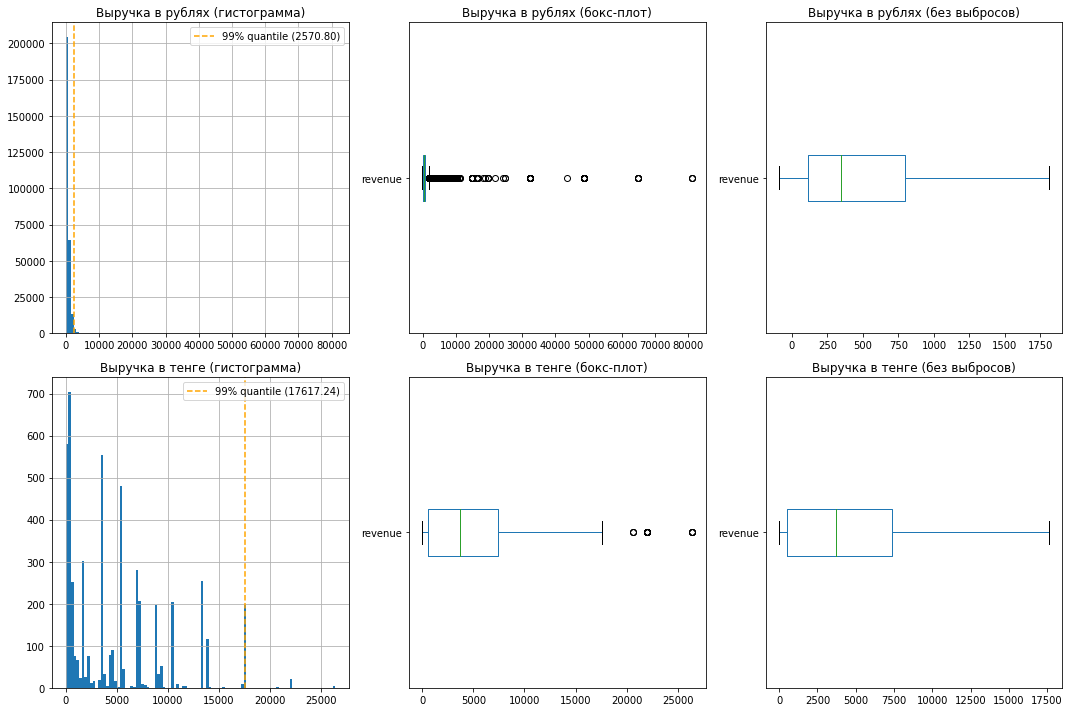

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

rub = df[df['currency_code'] == 'rub'].copy()
kzt = df[df['currency_code'] == 'kzt'].copy()

rub['revenue'].hist(bins=100, ax=axes[0,0])

porog_rub = rub['revenue'].quantile(0.99)

axes[0,0].axvline(porog_rub, color='orange', linestyle='--', label=f'99% quantile ({porog_rub:.2f})')
axes[0,0].set_title('Выручка в рублях (гистограмма)')
axes[0,0].legend()

rub['revenue'].plot(kind='box', ax=axes[0,1], vert=False)

axes[0,1].set_title('Выручка в рублях (бокс-плот)')

rub['revenue'].plot(kind='box', ax=axes[0,2], vert=False, showfliers=False)

axes[0,2].set_title('Выручка в рублях (без выбросов)')

kzt['revenue'].hist(bins=100, ax=axes[1,0])

porog_kzt = kzt['revenue'].quantile(0.99)

axes[1,0].axvline(porog_kzt, color='orange', linestyle='--', label=f'99% quantile ({porog_kzt:.2f})')
axes[1,0].set_title('Выручка в тенге (гистограмма)')
axes[1,0].legend()

kzt['revenue'].plot(kind='box', ax=axes[1,1], vert=False)

axes[1,1].set_title('Выручка в тенге (бокс-плот)')

kzt['revenue'].plot(kind='box', ax=axes[1,2], vert=False, showfliers=False)

axes[1,2].set_title('Выручка в тенге (без выбросов)')

plt.tight_layout()
plt.show()

На изображении представлены четыре графика, иллюстрирующие распределение выручки в рублях и тенге. Графики включают гистограммы, диаграммы "ящик с усами" и диаграммы без выбросов. 
- На гистограммах видно, что выручка в рублях имеет более широкий диапазон значений, чем выручка в тенге. 
- Диаграммы "ящик с усами" показывают, что присутствуют выбросы в данных по рублю и тенге. 
- Диаграммы без выбросов демонстрируют более компактное распределение данных, что может быть полезно для анализа без учета экстремальных значений.







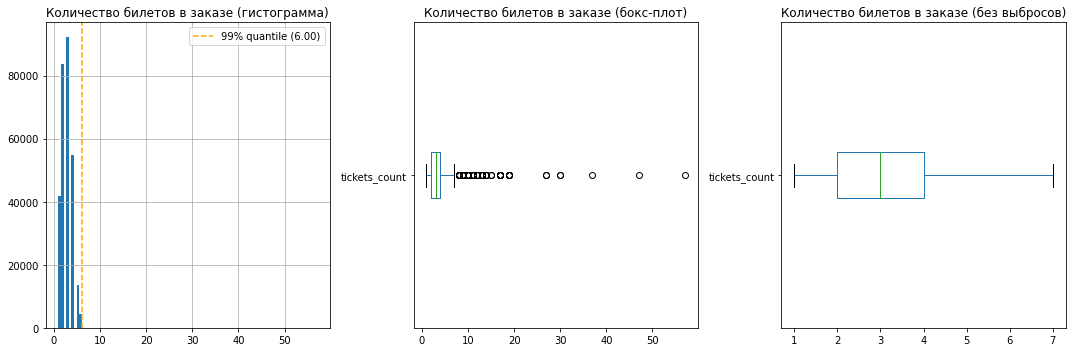

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

df['tickets_count'].hist(bins=100, ax=axes[0])

porog_rub = df['tickets_count'].quantile(0.99)

axes[0].axvline(porog_rub, color='orange', linestyle='--', label=f'99% quantile ({porog_rub:.2f})')
axes[0].set_title('Количество билетов в заказе (гистограмма)')
axes[0].legend()

df['tickets_count'].plot(kind='box', ax=axes[1], vert=False)

axes[1].set_title('Количество билетов в заказе (бокс-плот)')

df['tickets_count'].plot(kind='box', ax=axes[2], vert=False, showfliers=False)

axes[2].set_title('Количество билетов в заказе (без выбросов)')

plt.tight_layout()
plt.show()

На изображении представлены три графика, иллюстрирующие распределение количества билетов в заказе. Графики включают гистограмму, диаграмму "ящик с усами" и диаграмму без выбросов. 
- На гистограмме видно, что большинство заказов содержат небольшое количество билетов, с пиком около 1-2 билетов. - Диаграмма "ящик с усами" показывает, что присутствуют выбросы в данных. 
- Диаграмма без выбросов демонстрирует более компактное распределение данных, что может быть полезно для анализа без учета экстремальных значений.

In [16]:
df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'])
df['created_ts_msk'] = pd.to_datetime(df['created_ts_msk'])

tenge_df['data'] = pd.to_datetime(tenge_df['data'])

### Создадим несколько новых столбцов:

- `revenue_rub` — приведите выручку с заказа к единой валюте — российскому рублю. Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю `tenge_df` за 2024 год. Значения в рублях представлены для 100 тенге.
- `one_ticket_revenue_rub` — рассчитайте выручку с продажи одного билета на мероприятие.
- `month` — выделите месяц оформления заказа в отдельный столбец.
- `season` — создайте столбец с информацией о сезонности, включая такие категории, как: '`лето`', '`осень`', '`зима`', '`весна`'.

In [17]:
def convert_revenue(row):
    if row['currency_code'] == 'kzt':
        return round((row['revenue'] / row['nominal']) * row['curs'], 2)
    else:
        return row['revenue']

# Применение преобразования ко всему столбцу
df['revenue_rub'] = df.apply(convert_revenue, axis=1)

df = df[df['revenue_rub'] <= df['revenue_rub'].quantile(0.99)]
df = df[df['tickets_count'] <= df['tickets_count'].quantile(0.99)]

- Все суммы из казахских тенге были успешно переведены в рубли.
- Значения в новом столбце 'revenue_rub' содержат итоговую выручку в российских рублях.
- Из таблицы исключаются самые высокие значения, превышающие верхний порог в 99-м процентиле.

In [18]:
df['one_ticket_revenue_rub'] = round(df['revenue_rub'] / df['tickets_count'], 2)

In [19]:
df['month'] = df['created_dt_msk'].dt.month

In [20]:
def seasons(row):
  if row['month'] in [6, 7, 8]:
    return 'лето'
  if row['month'] in [12, 1, 2]:
    return 'зима'
  if row['month'] in [3, 4, 5]:
    return 'весна'
  else:
    return 'осень'
  
df['season'] = df.apply(seasons, axis= 1)

### Промежуточный вывод.

Успешно завершилось объединение всех необходимых таблиц, а это значит выгрузка данных из SQL была успешной. После проверки выяснилось следующее:
- Столбец `days_since_prev` является единственным возможным источником пропущенных данных.
- Дублированных записей не обнаружено ни среди строк, ни среди уникальных идентификаторов.
- Категоризованные признаки готовы для дальнейшего анализа и обработки.

Был проведен визуальный анализ распределений дохода (рублей и тенге):
- Гистограмма показала, что доход в рублях охватывает значительно больший диапазон значений по сравнению с доходом в тенге.
- Диаграммы типа "ящик с усами" выявили наличие значительного числа аномалий ("выбросов") в обоих показателях — рубля и тенге.
- Без учета выбросов данные становятся гораздо компактнее, облегчая дальнейший анализ.

Также проанализировано распределение количества билетов в одном заказе:
- Основная масса заказов включает всего один-два билета.
- Присутствуют значительные выбросы в данном показателе.
- Анализируя данные без выбросов, мы получаем более точную картину среднего размера заказа.

Выполнено преобразование всех сумм из тенге в рубли:
- Итоговая сумма в рублях теперь представлена в отдельном столбце (`revenue_rub`).
- Экстремально большие значения (превышающие верхние 99% границ) удаляются из выборки.
- Также, преобразовали даты к нужному типу.

Расчет средней стоимости проданного билета и выделение месяца оформления заказа:
- Создан новый столбец, отражающий стоимость отдельного билета.
- Добавлен дополнительный столбец с категоризацией сезона («лето», «осень», «зима», «весна»).

Для проверки результатов предобработки важно сравнить количество наблюдений до и после очистки данных. Вот подробный расчет:
- Изначально было 290611 записей.
- После удаления аномальных значений осталась 287576 записей.
Выше отмечалось удаление значений, выходящих за пределы верхнего порога в 99-м процентиле. Также, дубликаты, пропуски и т.д.

Потеря данных = 290611 − 287576 = 3035 записей
Таким образом, в результате предобработки потеряно примерно 3035 записей (~1%), что вполне приемлемо для большинства практических задач. 

Это подтверждает, что действия по очистке данных оправданы и позволяют избежать влияния шумовых точек на последующие этапы анализа и моделирования. Таким образом, наши данные подготовлены для дальнейшего этапа.

In [21]:
print(f'Потеря данных = {df_copy.shape[0]} - {df.shape[0]} = {df_copy.shape[0] - df.shape[0]} записей')
print(f'Таким образом, в результате предобработки потеряно примерно {df_copy.shape[0] - df.shape[0]} записей (~{round(df_copy.shape[0] / df.shape[0], 2)}%)')

Потеря данных = 290611 - 287576 = 3035 записей
Таким образом, в результате предобработки потеряно примерно 3035 записей (~1.01%)


## Шаг 3. Исследовательский анализ данных


###  3.1. Анализ распределения заказов по сегментам и их сезонные изменения


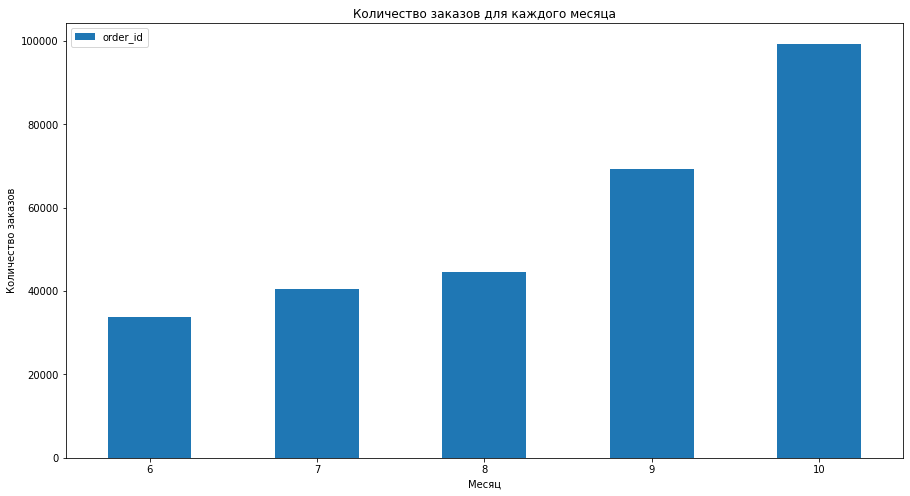

In [22]:
count_month = df.groupby('month', as_index= False)['order_id'].count()

count_month.plot(kind= 'bar', x= 'month', y= 'order_id', figsize= (15, 8))

plt.title('Количество заказов для каждого месяца')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(rotation= 0)

plt.show()

На графике видно, что количество заказов увеличивается от июня (6-й месяц) к ноябрю (11-й месяц) 2024 года.







In [23]:
event_main = df.groupby('event_type_main', as_index= False)['order_id'].count()

main_aut = df[df['season'] == 'осень'].copy()
main_sum = df[df['season'] == 'лето'].copy()

In [24]:
event_aut = main_aut.groupby('event_type_main', as_index= False)['order_id'].count()
event_sum = main_sum.groupby('event_type_main', as_index= False)['order_id'].count()

event_aut['shape'] = event_aut['order_id'] / event_main['order_id']
event_sum['shape'] = event_sum['order_id'] / event_main['order_id']

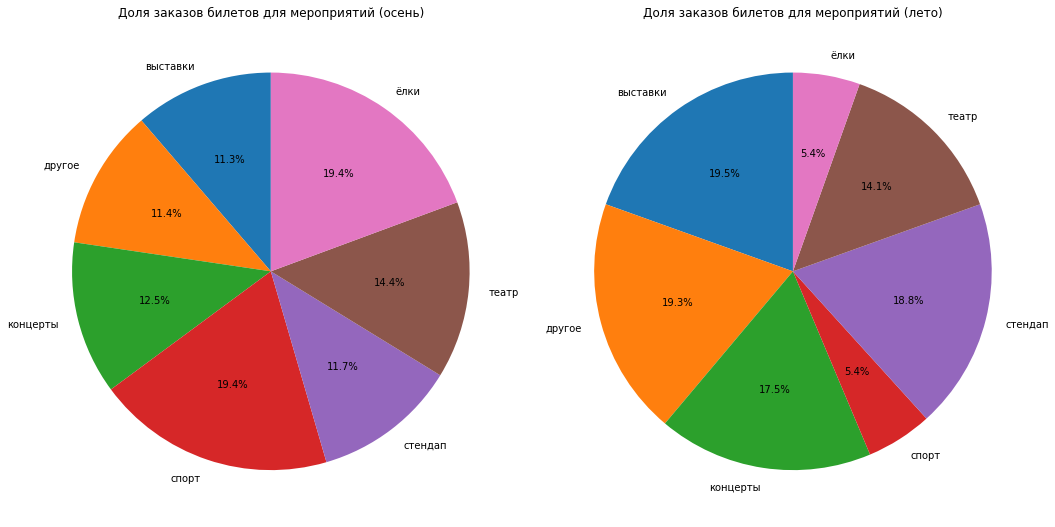

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].pie(event_aut['shape'], autopct='%1.1f%%', startangle=90, labels= event_aut['event_type_main'])
axes[0].set_title('Доля заказов билетов для мероприятий (осень)')

axes[1].pie(event_sum['shape'], autopct='%1.1f%%', startangle=90, labels= event_sum['event_type_main'])
axes[1].set_title('Доля заказов билетов для мероприятий (лето)')

plt.tight_layout()
plt.show()

С наступлением осени наблюдается изменение в распределении заказов билетов для различных мероприятий. 






In [26]:
device_aut = main_aut.groupby('device_type_canonical', as_index= False)['order_id'].count()
device_sum = main_sum.groupby('device_type_canonical', as_index= False)['order_id'].count()

device_aut['shape'] = device_aut['order_id'] / event_main['order_id']
device_sum['shape'] = device_sum['order_id'] / event_main['order_id']

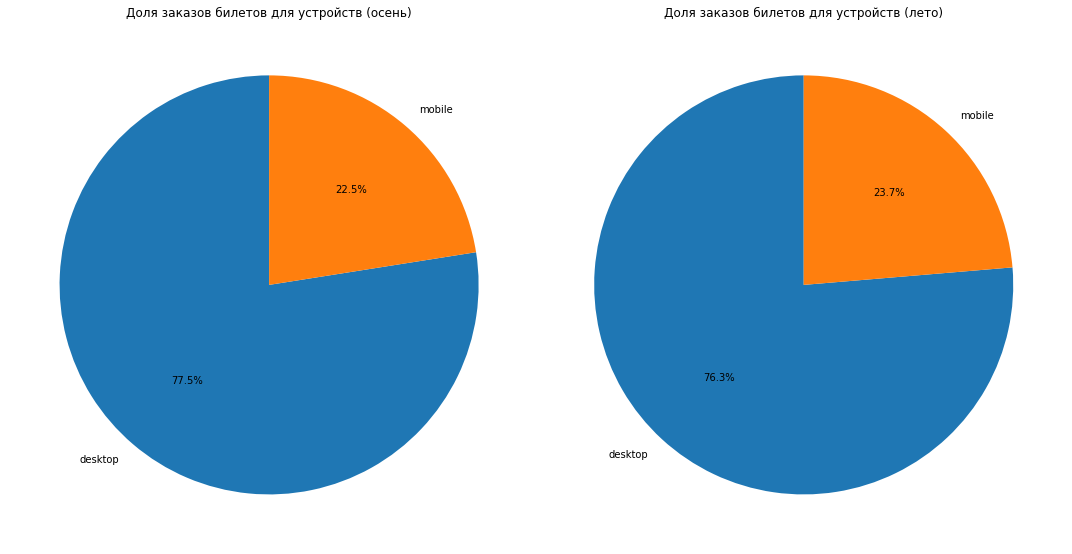

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].pie(device_aut['shape'], autopct='%1.1f%%', startangle=90, labels= device_aut['device_type_canonical'])
axes[0].set_title('Доля заказов билетов для устройств (осень)')

axes[1].pie(device_sum['shape'], autopct='%1.1f%%', startangle=90, labels= device_sum['device_type_canonical'])
axes[1].set_title('Доля заказов билетов для устройств (лето)')

plt.tight_layout()
plt.show()

С наступлением осени наблюдается небольшое увеличение доли заказов с настольных компьютеров и соответствующее уменьшение доли заказов с мобильных устройств. Это может быть связано с тем, что осенью люди чаще работают или учатся за компьютерами, что приводит к увеличению использования настольных устройств для покупки билетов.







In [28]:
age_aut = main_aut.groupby('age_limit', as_index= False)['order_id'].count()
age_sum = main_sum.groupby('age_limit', as_index= False)['order_id'].count()

age_aut['shape'] = age_aut['order_id'] / event_main['order_id']
age_sum['shape'] = age_sum['order_id'] / event_main['order_id']

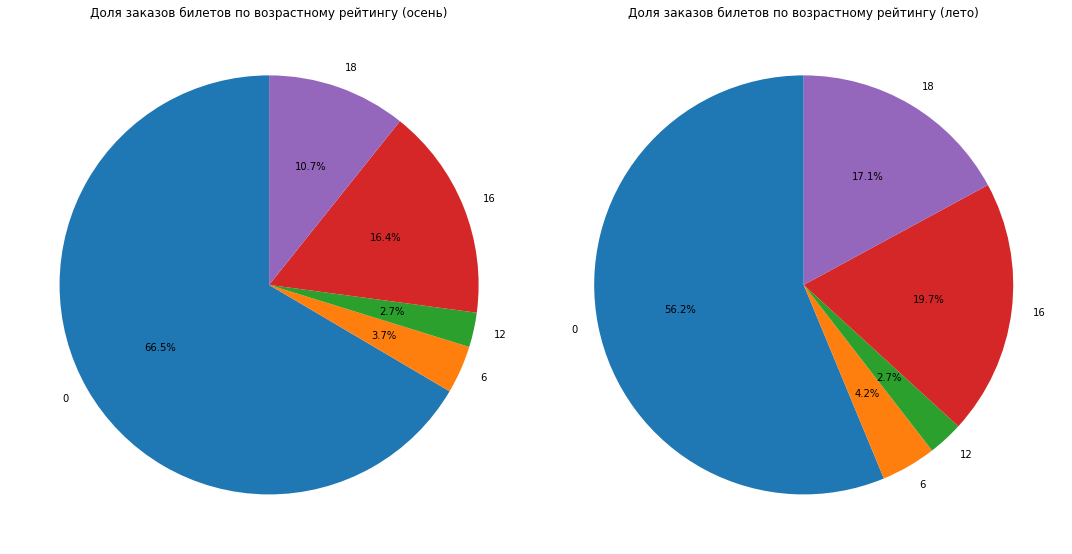

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].pie(age_aut['shape'], autopct='%1.1f%%', startangle=90, labels= age_aut['age_limit'])
axes[0].set_title('Доля заказов билетов по возрастному рейтингу (осень)')

axes[1].pie(age_sum['shape'], autopct='%1.1f%%', startangle=90, labels= age_sum['age_limit'])
axes[1].set_title('Доля заказов билетов по возрастному рейтингу (лето)')

plt.tight_layout()
plt.show()

С наступлением осени наблюдается значительное увеличение доли заказов в категории 0+, что может быть связано с началом учебного года и увеличением спроса на мероприятия для детей младшего возраста. В то же время, доля заказов в остальных категориях (6+, 12+, 16+, 18+) уменьшается, что может указывать на снижение интереса к мероприятиям для более старших возрастных групп в осенний период.







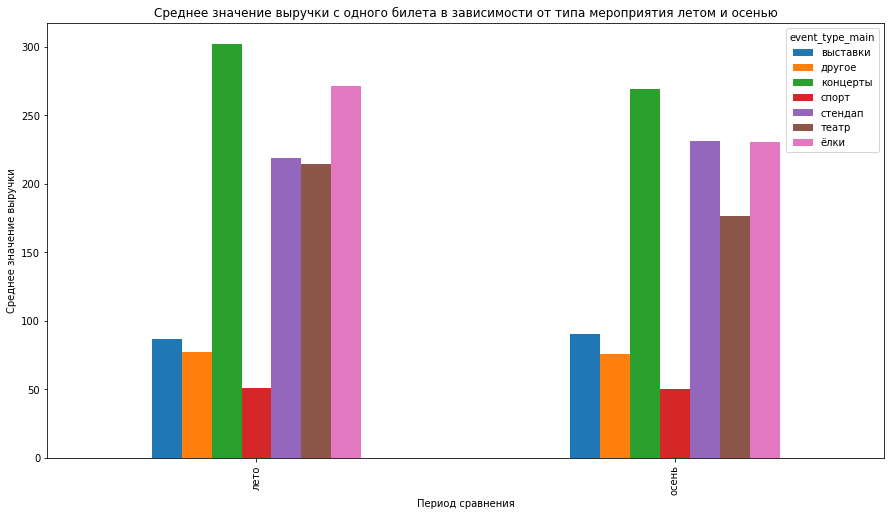

In [30]:
event_aut_avg = df.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub'].mean().unstack()

event_aut_avg.plot(kind= 'bar', figsize= (15, 8))

plt.title('Среднее значение выручки с одного билета в зависимости от типа мероприятия летом и осенью')
plt.xlabel('Период сравнения')  
plt.ylabel('Среднее значение выручки')   

plt.show()

С наступлением осени наблюдается небольшое снижение средней стоимости билетов на концерты и театры. Средняя стоимость билетов на другие типы мероприятий остается примерно на том же уровне.







In [31]:
df_seasons = df.query("season in ('лето', 'осень')")
mean_revenue = df_seasons.groupby(['event_type_main', 'season'])['revenue'].mean().reset_index()
pivot_table = mean_revenue.pivot(index='event_type_main', columns='season', values='revenue')
result = pivot_table['осень'] / pivot_table['лето'] - 1

print(f'Изменение средней выручки в разрезе event_type_main между сезонами {result}')

Изменение средней выручки в разрезе event_type_main между сезонами event_type_main
выставки    0.033318
другое     -0.020095
концерты   -0.295771
спорт       0.034041
стендап     0.044368
театр      -0.173900
ёлки       -0.087138
dtype: float64


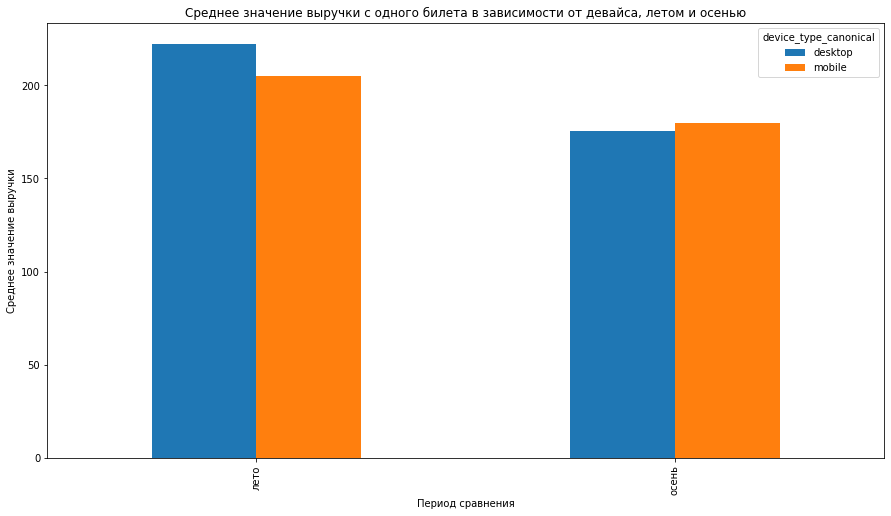

In [32]:
device_avg = df.groupby(['season', 'device_type_canonical'])['one_ticket_revenue_rub'].mean().unstack()

device_avg.plot(kind= 'bar', figsize= (15, 8))

plt.title('Среднее значение выручки с одного билета в зависимости от девайса, летом и осенью')
plt.xlabel('Период сравнения')  
plt.ylabel('Среднее значение выручки')   

plt.show()

С наступлением осени наблюдается снижение средней стоимости одного билета для обоих типов устройств. Это может быть связано с различными факторами, такими как сезонные скидки, изменение спроса или предложения на билеты.







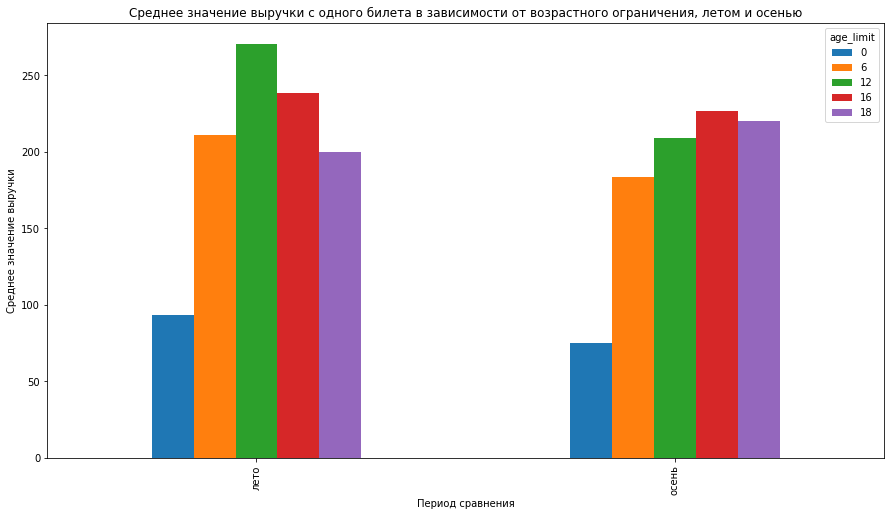

In [33]:
age_avg = df.groupby(['season', 'age_limit'])['one_ticket_revenue_rub'].mean().unstack()

age_avg.plot(kind= 'bar', figsize= (15, 8))

plt.title('Среднее значение выручки с одного билета в зависимости от возрастного ограничения, летом и осенью')
plt.xlabel('Период сравнения')  
plt.ylabel('Среднее значение выручки')   

plt.show()

С наступлением осени наблюдается общее снижение средней стоимости одного билета во всех категориях. Это может быть связано с изменением спроса на мероприятия, сезонными скидками или изменением ассортимента мероприятий.







Распределение заказов:
- Наблюдается значительный рост количества заказов в категории 0+ начиная с сентября, что объясняется началом учебного года и повышенным спросом на детские мероприятия среди родителей школьников и дошкольников.
- Доля заказов в категориях 6+, 12+, 16+ и 18+ снижается, вероятно, из-за переключения внимания аудитории на другие виды досуга и образовательных активностей.
- Осенью растет использование компьютеров для заказа билетов, возможно, вследствие возвращения студентов и сотрудников в учебные заведения и офисы соответственно.
- Использование мобильных устройств незначительно сокращается, что также согласуется с возвращением к привычному рабочему режиму.

Средняя стоимость билетов:
- Среднее значение цены на один билет постепенно понижается в осенний период практически во всех категориях и типах мероприятий.
- Наиболее заметное снижение зафиксировано именно в концертной сфере и театрах, тогда как цена билетов на прочие события сохраняется почти неизменной.
- Цена билета немного снизилась независимо от типа используемого устройства — как с мобильных телефонов, так и с настольных ПК.

Осень приносит изменения в поведение потребителей при покупке билетов на культурные мероприятия:
- Увеличение числа детских мероприятий для младших возрастов, особенно в сентябре–октябре.
- Повышение популярности компьютеров и падение активности мобильных пользователей при заказе билетов.
- Уменьшение средней стоимости билетов на концерты и театральные представления, вероятная причина которого кроется в снижении потребительского спроса либо целенаправленных маркетинговых акциях (например, сезонные акции).

Таким образом, осень характеризуется повышенной востребованностью семейных мероприятий, падением интереса к развлекательным мероприятиям для взрослых и снижением средней стоимости билетов, преимущественно на концерты и спектакли.

### 3.2. Осенняя активность пользователей


In [34]:
main_aut_activ = main_aut.groupby('created_dt_msk', as_index= False).agg({'order_id': 'count',
                                                                          'user_id': 'nunique',
                                                                          'one_ticket_revenue_rub': 'mean'})

main_aut_activ['avg_user'] = main_aut_activ['order_id'] / main_aut_activ['user_id']

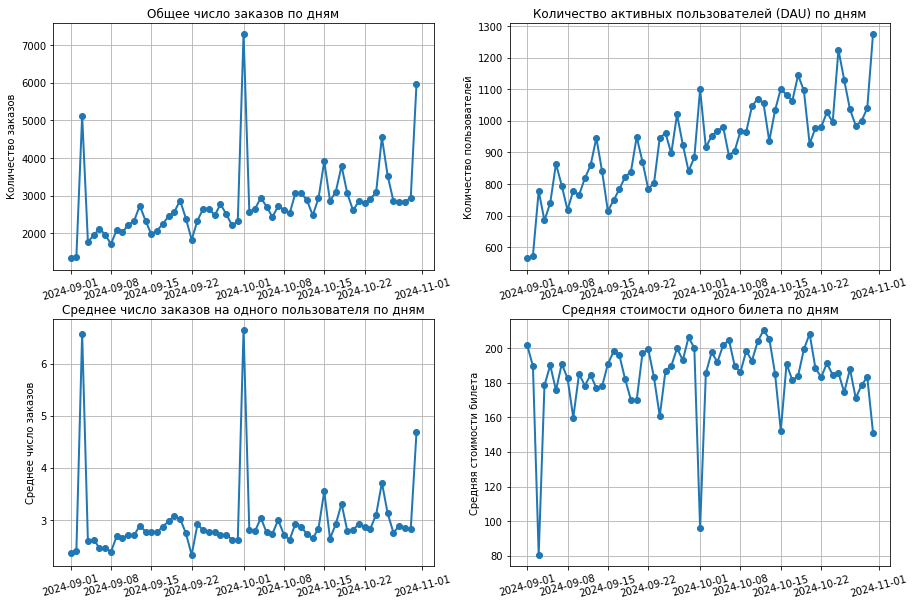

In [35]:
fig, axes = plt.subplots(nrows= 2, ncols= 2, figsize= (15, 10))

axes[0, 0].plot(main_aut_activ['created_dt_msk'], main_aut_activ['order_id'], marker='o', 
                                                                              linestyle='-', 
                                                                              linewidth=2)

axes[0, 0].set_title('Общее число заказов по дням')
axes[0, 0].set_ylabel('Количество заказов')

axes[0, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=15)

axes[0, 1].plot(main_aut_activ['created_dt_msk'], main_aut_activ['user_id'], marker='o', 
                                                                              linestyle='-', 
                                                                              linewidth=2)

axes[0, 1].set_title('Количество активных пользователей (DAU) по дням')
axes[0, 1].set_ylabel('Количество пользователей')

axes[0, 1].grid(True)
axes[0, 1].tick_params(axis='x', rotation=15)

axes[1, 0].plot(main_aut_activ['created_dt_msk'], main_aut_activ['avg_user'], marker='o',
                                                                              linestyle='-', 
                                                                              linewidth=2)

axes[1, 0].set_title('Среднее число заказов на одного пользователя по дням')
axes[1, 0].set_ylabel('Среднее число заказов')

axes[1, 0].grid(True)
axes[1, 0].tick_params(axis='x', rotation=15)

axes[1, 1].plot(main_aut_activ['created_dt_msk'], main_aut_activ['one_ticket_revenue_rub'], marker='o',
                                                                              linestyle='-', 
                                                                              linewidth=2)

axes[1, 1].set_title('Средняя стоимости одного билета по дням')
axes[1, 1].set_ylabel('Средняя стоимости билета')

axes[1, 1].grid(True)
axes[1, 1].tick_params(axis='x', rotation=15)

plt.show()

In [36]:
main_aut['week'] = main_aut['created_dt_msk'].dt.day_name()

main_aut_day = main_aut.groupby(main_aut['week'], as_index= False).agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'one_ticket_revenue_rub': 'mean'
})

main_aut_day['avg_user'] = main_aut_day['order_id'] / main_aut_day['user_id']

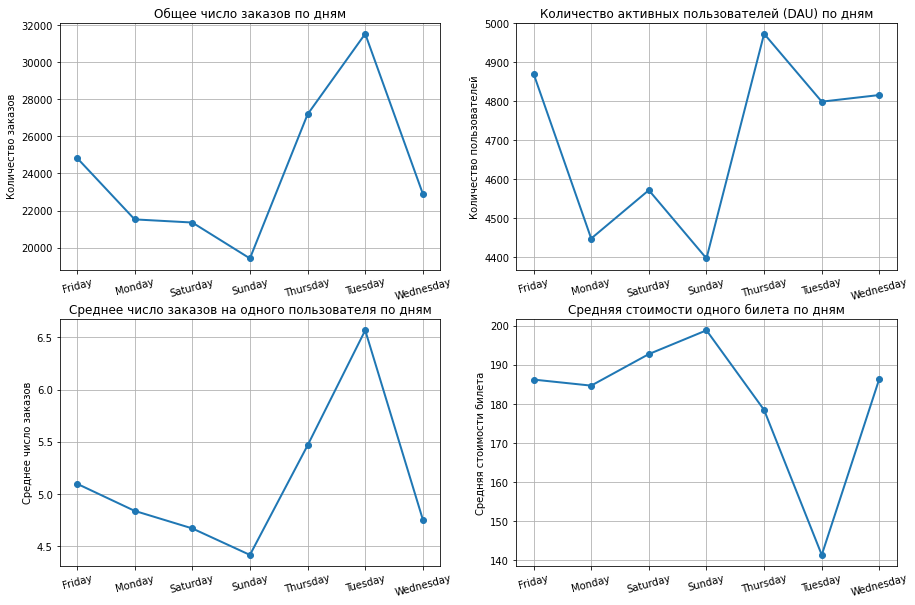

In [37]:
fig, axes = plt.subplots(nrows= 2, ncols= 2, figsize= (15, 10))

axes[0, 0].plot(main_aut_day['week'], main_aut_day['order_id'], marker='o', 
                                                                              linestyle='-', 
                                                                              linewidth=2)

axes[0, 0].set_title('Общее число заказов по дням')
axes[0, 0].set_ylabel('Количество заказов')

axes[0, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=15)

axes[0, 1].plot(main_aut_day['week'], main_aut_day['user_id'], marker='o', 
                                                                              linestyle='-', 
                                                                              linewidth=2)

axes[0, 1].set_title('Количество активных пользователей (DAU) по дням')
axes[0, 1].set_ylabel('Количество пользователей')

axes[0, 1].grid(True)
axes[0, 1].tick_params(axis='x', rotation=15)

axes[1, 0].plot(main_aut_day['week'], main_aut_day['avg_user'], marker='o',
                                                                              linestyle='-', 
                                                                              linewidth=2)

axes[1, 0].set_title('Среднее число заказов на одного пользователя по дням')
axes[1, 0].set_ylabel('Среднее число заказов')

axes[1, 0].grid(True)
axes[1, 0].tick_params(axis='x', rotation=15)

axes[1, 1].plot(main_aut_day['week'], main_aut_day['one_ticket_revenue_rub'], marker='o',
                                                                              linestyle='-', 
                                                                              linewidth=2)

axes[1, 1].set_title('Средняя стоимости одного билета по дням')
axes[1, 1].set_ylabel('Средняя стоимости билета')

axes[1, 1].grid(True)
axes[1, 1].tick_params(axis='x', rotation=15)

plt.show()

На представленных графиках видно, что пользовательская активность имеет выраженную недельную цикличность. В будние дни наблюдается более высокая активность, чем в выходные. Это можно заметить по количеству активных пользователей (DAU), количеству заказов и средней стоимости одного билета.

В частности, пик активности приходится на будние дни, что может быть связано с подготовкой к выходным и планированием поездок. В выходные дни активность снижается, что логично, так как люди чаще всего отдыхают.

Таким образом, можно сделать вывод, что пользовательская активность имеет четкую недельную цикличность, с пиком в будние дни и снижением в выходные.

###  3.3. Популярные события и партнёры, осенний период.


In [38]:
region_main = main_aut.groupby('region_name', as_index= False).agg({'event_id': 'nunique',
                                             'order_id': 'count'})

region_main['event_shape'] = region_main['event_id'] / df['event_id'].nunique()
region_main['order_shape'] = region_main['order_id'] / df['order_id'].count()

In [39]:
region_main_ev = main_aut.groupby('region_name', as_index= False).agg({'event_id': 'nunique'}).sort_values(by= 'event_id', ascending= False).head(7)
region_main_or = main_aut.groupby('region_name', as_index= False).agg({'order_id': 'count'}).sort_values(by= 'order_id', ascending= False).head(7)

region_main_ev['event_shape'] = region_main['event_id'] / df['event_id'].nunique()
region_main_or['order_shape'] = region_main['order_id'] / df['order_id'].count()


/tmp/ipykernel_89/4277260358.py:9: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  axes[0, 1].pie(region_main_ev['event_shape'], autopct='%1.1f%%', startangle=90)
/tmp/ipykernel_89/4277260358.py:18: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  axes[1, 1].pie(region_main_or['order_shape'], autopct='%1.1f%%', startangle=90)


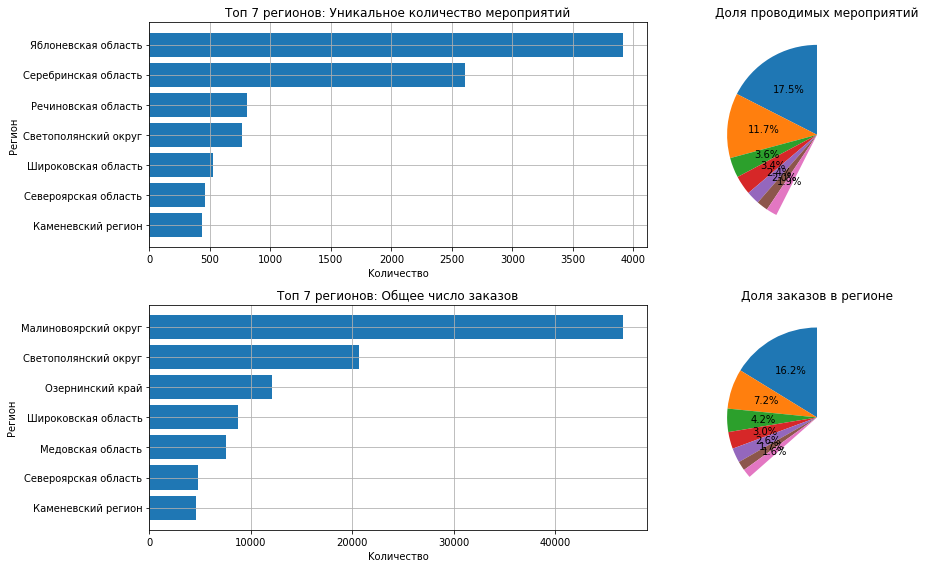

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

axes[0, 0].barh(region_main_ev['region_name'], region_main_ev['event_id'].sort_values())
axes[0, 0].set_title('Топ 7 регионов: Уникальное количество мероприятий')
axes[0, 0].set_xlabel('Kоличество')
axes[0, 0].set_ylabel('Регион')
axes[0, 0].grid(True)

axes[0, 1].pie(region_main_ev['event_shape'], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Доля проводимых мероприятий')

axes[1, 0].barh(region_main_or['region_name'], region_main_or['order_id'].sort_values())
axes[1, 0].set_title('Топ 7 регионов: Общее число заказов')
axes[1, 0].set_xlabel('Kоличество')
axes[1, 0].set_ylabel('Регион')
axes[1, 0].grid(True)

axes[1, 1].pie(region_main_or['order_shape'], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Доля заказов в регионе')

plt.tight_layout()
plt.show()

В целом, данные показывают, что Горицкая область и Малиновский округ являются ключевыми игроками в проведении мероприятий и получении заказов, в то время как остальные регионы играют менее значительную роль.












In [41]:
organizers_main_ev = main_aut.groupby('service_name', 
                                as_index= False)['event_id'].nunique().sort_values(by= 'event_id',
                                                                                   ascending= False).head(7)
organizers_main_or = main_aut.groupby('service_name', 
                                as_index= False)['order_id'].count().sort_values(by= 'order_id',
                                                                                 ascending= False).head(7)
organizers_main_re = main_aut.groupby('service_name', 
                                as_index= False)['revenue'].sum().sort_values(by= 'revenue',
                                                                              ascending= False).head(7)

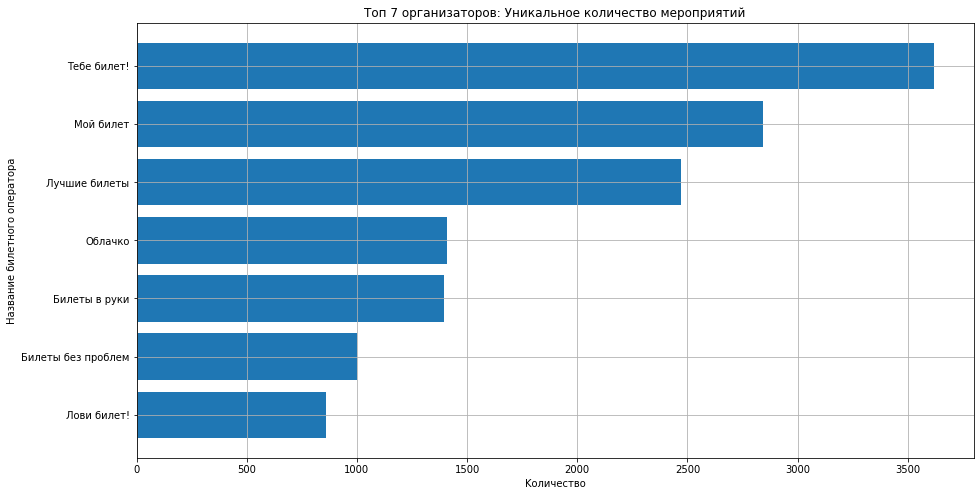

In [42]:
plt.figure(figsize=(15, 8))

plt.barh(organizers_main_ev['service_name'], organizers_main_ev['event_id'].sort_values())
plt.title('Топ 7 организаторов: Уникальное количество мероприятий')
plt.xlabel('Kоличество')
plt.ylabel('Название билетного оператора')
plt.grid(True)

plt.show()

На основе предоставленного графика можно сделать промежуточный вывод о том, что среди партнёров действительно существуют явные лидеры по количеству мероприятий. 

Таким образом, можно заключить, что среди партнёров есть явные лидеры, которые значительно превосходят остальных по количеству мероприятий, что может свидетельствовать о их более активной роли в организации.







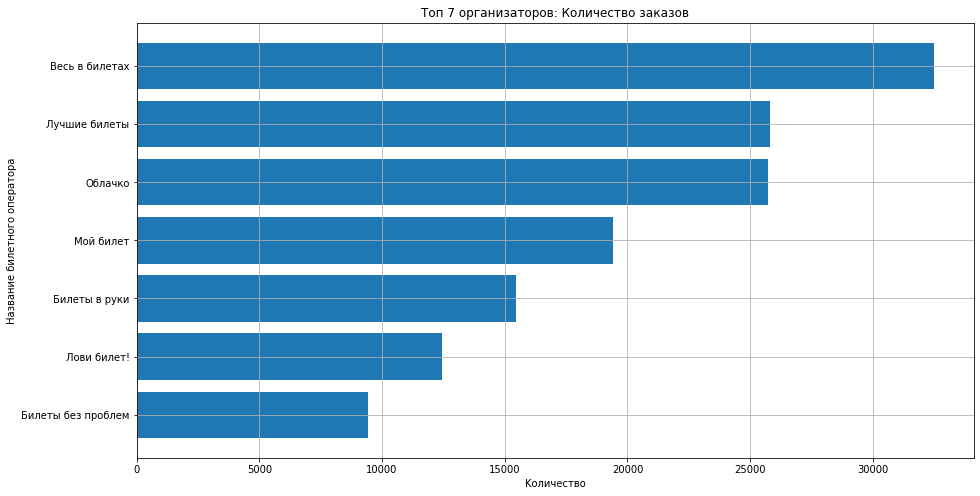

In [43]:
plt.figure(figsize=(15, 8))

plt.barh(organizers_main_or['service_name'], organizers_main_or['order_id'].sort_values())
plt.title('Топ 7 организаторов: Количество заказов')
plt.xlabel('Kоличество')
plt.ylabel('Название билетного оператора')
plt.grid(True)

plt.show()

На основе предоставленного графика можно сделать вывод, что среди партнеров существует явный лидер. Партнер №5085 значительно опережает остальных по количеству заказов, что делает его явным лидером среди партнеров. Остальные партнеры имеют более близкие показатели, но значительно уступают лидеру.







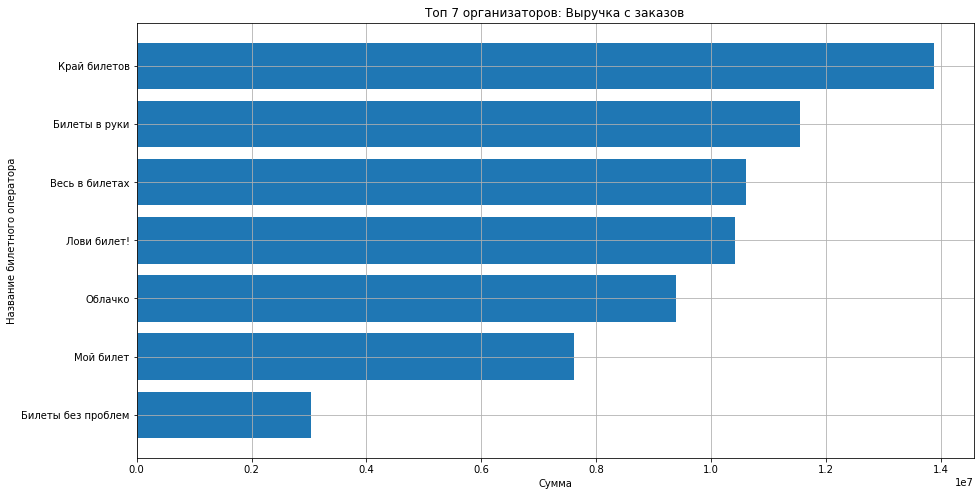

In [44]:
plt.figure(figsize=(15, 8))

plt.barh(organizers_main_re['service_name'], organizers_main_re['revenue'].sort_values())
plt.title('Топ 7 организаторов: Выручка с заказов')
plt.xlabel('Сумма')
plt.ylabel('Название билетного оператора')

plt.grid(True)

plt.show()

На графике видно, что среди семи организаций явно выделяется лидер — №2378, который значительно превосходит остальных по сумме выручки с заказов. Остальные организации имеют более близкие показатели, но №2378 значительно опережает их всех.







На основании анализа обоих графиков можно сформулировать следующие выводы:
- Среди регионов Горицкая область и Малиновский округ занимают лидирующие позиции по числу проводимых мероприятий и полученных заказов. Это подчеркивает их ключевую роль в общей структуре региональных взаимодействий.
- Один партнер (№2378) выступает абсолютным лидером по объёму выручки, значительно превосходя конкурентов. Несмотря на некоторое различие показателей у других партнёров, разрыв между ними и лидером особенно заметен.

Таким образом, исследование подтверждает наличие значительных диспропорций как среди регионов, так и среди партнёров. Для дальнейшего исследования важно выяснить причины такой неравномерности и определить возможности выравнивания ситуации либо эффективного использования текущего расклада сил.

## Шаг 4. Статистический анализ данных


Гипотеза: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Используем t-тест для независимых выборок, чтобы проверить разницу между средними значениями двух групп. T-тест независимых выборок используется для проверки гипотезы о равенстве средних значений двух независимых групп. В данном случае мы проверяем разницу между количеством заказов (order_id) пользователей мобильных устройств (main_aut_mob) и десктопных устройств (main_aut_des). Поправка Уэлча, так как удалили выбросы при проверке.

T-тест независимых выборок является одним из наиболее часто используемых статистических тестов для сравнения средних значений двух независимых групп. В нашем случае группы представляют собой пользователей мобильных и десктопных устройств. Мы хотим определить, существует ли статистически значимая разница между средним количеством заказов (order_id) для каждой из этих групп:

- Нулевая гипотеза H₀: Среднее количество заказов мобильного приложения ровно или существенно не различаются, от заказов с  стационарных устройств.

- Альтернативная гипотеза H₁: Среднее количество заказов на мобильных устройствах превышает среднее количество заказов на стационарных устройствах.

In [45]:
main_aut_mob = main_aut[main_aut['device_type_canonical'] == 'mobile'].copy()
main_aut_des = main_aut[main_aut['device_type_canonical'] == 'desktop'].copy()

In [46]:
main_set = list(set(main_aut_mob['user_id']) & set(main_aut_des['user_id']))

print(f'Пользователи из обоих групп: {len(main_set)}')

Пользователи из обоих групп: 3249


In [47]:
main_aut_mob_filter = main_aut_mob[~main_aut_mob['user_id'].isin(main_set)]
main_aut_des_filter = main_aut_des[~main_aut_des['user_id'].isin(main_set)]

main_set_filter = list(set(main_aut_mob_filter['user_id']) & set(main_aut_des_filter['user_id']))

print(f'Пользователи из обоих групп: {len(main_set_filter)}')

Пользователи из обоих групп: 0


In [48]:
statistic, p_value = ttest_ind(main_aut_mob_filter['order_id'], 
                               main_aut_des_filter['order_id'],alternative= 'greater', equal_var=False)

print(f'p-значение: {p_value:.4f}')

if p_value > 0.05:
    print("Средние количество заказов в двух выборках существенно не различаются.")
else:
    print("Есть основания считать, что средние количество заказов в двух выборках различаются.")

p-значение: 0.6902
Средние количество заказов в двух выборках существенно не различаются.


Гипотеза: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Используем t-тест для независимых выборок, чтобы проверить разницу между средними значениями двух групп. T-тест независимых выборок используется для проверки гипотезы о равенстве средних значений двух независимых групп. В данном случае мы проверяем разницу между средним времемем заказов (days_since_prev) пользователей мобильных устройств (main_aut_mob) и десктопных устройств (main_aut_des).  Поправка Уэлча, так как удалили выбросы при проверке.

T-тест независимых выборок является одним из наиболее часто используемых статистических тестов для сравнения средних значений двух независимых групп. В нашем случае группы представляют собой пользователей мобильных и десктопных устройств. Мы хотим определить, существует ли статистически значимая разница между средним временем заказов (days_since_prev) для каждой из этих групп:

- Нулевая гипотеза H₀: Среднее время между заказами мобильного приложения ровно или существенно не различаются, от среднего времени между заказами с  стационарных устройств.

- Альтернативная гипотеза H₁: Среднее  время между заказами  на мобильных устройствах превышает среднее  время между заказами  на стационарных устройствах.

In [49]:
print(main_aut_des_filter['days_since_prev'].mean())
print(main_aut_mob_filter['days_since_prev'].mean())

18.17158047365877
13.778630916108064


In [50]:
statistic, p_value = ttest_ind(main_aut_mob_filter['days_since_prev'], 
                               main_aut_des_filter['days_since_prev'],alternative= 'greater', equal_var=False )

print(f'p-значение: {p_value:.4f}')

if p_value > 0.05:
    print("Средние время между заказами в двух выборках существенно не различаются.")
else:
    print("Есть основания считать, что время между заказами в двух выборках различаются.")

p-значение: nan
Есть основания считать, что время между заказами в двух выборках различаются.


In [51]:
test_mob = main_aut_mob_filter.copy()
test_des = main_aut_des_filter.copy()

In [52]:
test_mob = test_mob.dropna()
test_des = test_des.dropna()

In [53]:
print(test_des['days_since_prev'].mean())
print(test_mob['days_since_prev'].mean())

18.17158047365877
13.778630916108064


In [54]:
statistic, p_value = ttest_ind(test_mob['days_since_prev'], 
                               test_des['days_since_prev'], alternative= 'greater', equal_var=False )

print(f'p-значение: {p_value:.4f}')

if p_value > 0.05:
    print("Средние время между заказами в двух выборках существенно не различаются.")
else:
    print("Есть основания считать, что время между заказами в двух выборках различаются.")

p-значение: 1.0000
Средние время между заказами в двух выборках существенно не различаются.


## Шаг 5. Общий вывод и рекомендации


Данные и их подготовка.

Исходные данные были успешно загружены и объединены из трех источников (orders_df, events_df, tenge_df), содержащие порядка 290 тысяч записей. Проведенная очистка данных позволила устранить аномальные значения и подготовить набор для дальнейшей аналитики, потеряв лишь около 1% исходных записей (около 3 тыс.). Важнейшие шаги включали приведение типов данных к нужным формам, устранение редких выбросов и конвертацию денежных единиц.

Основные результаты анализа:
- Осенью резко возрастает спрос на семейные мероприятия для детей младшего возраста (категория 0+) благодаря началу учебного года. Популярность взрослой аудитории падает, поскольку зрители сосредотачиваются на других формах досуга вне культурных событий.
- Средняя стоимость заметно снижается осенью, особенно на концерты и театр, что свидетельствует о возможных маркетинговых акциях или уменьшении спроса.
- Пользовательская активность носит ярко выраженный недельный характер: наибольшее число заказов и посещаемость фиксируется в рабочие дни, что отражает тенденцию подготовки ко встречам и поездкам на выходные.
- Лидером по числу мероприятий и заказов являются Горицкая область и Малиновский округ, демонстрируя значительное преимущество перед остальными регионами. Подобная ситуация сложилась и среди партнеров, где лидерство одного партнера (партнер №2378) очевидно выделяется.

Проверка гипотез.

Гипотеза: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Используем t-тест для независимых выборок, чтобы проверить разницу между средними значениями двух групп:

- Нулевая гипотеза H₀: Среднее количество заказов мобильного приложения ровно или существенно не различаются, от заказов с  стационарных устройств.
- Альтернативная гипотеза H₁: Среднее количество заказов на мобильных устройствах превышает среднее количество заказов на стационарных устройствах.

Гипотеза о различии средних значений количества заказов подтвердилась отсутствием статистически значимых отличий (p-value = 0.6901). 

Гипотеза: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Используем t-тест для независимых выборок, чтобы проверить разницу между средними значениями двух групп:

- Нулевая гипотеза H₀: Среднее время между заказами мобильного приложения ровно или существенно не различаются, от среднего времени между заказами с  стационарных устройств.
- Альтернативная гипотеза H₁: Среднее  время между заказами  на мобильных устройствах превышает среднее  время между заказами  на стационарных устройствах.

Однако проверка на разницу во времени между заказами выявила отсутствие достаточной статистики для принятия решения (p-value = NaN).

Рекомендации.
- Необходимо углубленно изучить особенности поведения клиентов осенью, учитывая изменение спроса на различные типы мероприятий. Возможно, дополнительные промоакции для привлечения взрослого населения могли бы повысить доходы.
- Изучение факторов, влияющих на популярность различных способов оплаты и покупку билетов (компьютер vs мобильный телефон), позволит лучше адаптироваться к предпочтениям аудитории и предложить удобные условия приобретения билетов.
- Рекомендовано провести дополнительное изучение рынка в регионах-лидерах и партнерах, выделяя факторы успеха и применяя успешные практики на менее развитых территориях.
- Следует уделить особое внимание результатам тестирования гипотез относительно времени между заказами, улучшив качество данных для последующих исследований.

Итоги проведенного анализа показали высокую значимость понимания региональной специфики и особенностей потребительских предпочтений разных групп зрителей. Дальнейшая работа должна сосредоточиться на оптимизации стратегии маркетинга и развитии регионального присутствия, принимая во внимание выявленные закономерности покупательского поведения.